# MSCA 31009 Machine Learning & Predictive Analytics

## Deep Learning Class Project

### Minh Vo
### 05/15/2023

### Import Libraries

In [1]:
!pip install keras-tuner --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import sys
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optparse

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

from keras.callbacks import TensorBoard, EarlyStopping
from keras.models import Sequential, load_model
from keras.layers import Activation, Conv1D, BatchNormalization, Dense, Dropout, LSTM, Flatten, Input
from keras.layers.convolutional import MaxPooling1D
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
from keras.preprocessing.text import Tokenizer

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Data Processing



For each record in the dataset it is provided:
- Triaxial acceleration from the accelerometer (total acceleration) and the estimated body acceleration.
- Triaxial Angular velocity from the gyroscope.
- A 561-feature vector with time and frequency domain variables.
- Its activity label.
- An identifier of the subject who carried out the experiment.

In [4]:
train = pd.read_csv("/content/gdrive/My Drive/Colab Datasets/ML Final Data/train.csv")
test = pd.read_csv("/content/gdrive/My Drive/Colab Datasets/ML Final Data/test.csv")

print(f"Train Data Shape: {train.shape}")
print(f"Test Data Shape: {test.shape}")

Train Data Shape: (7352, 563)
Test Data Shape: (2947, 563)


In [5]:
print(f"Missing Values in Train Data: {train.isnull().values.sum()}")
print(f"Missing Values in Test Data: {test.isnull().values.sum()}")

Missing Values in Train Data: 0
Missing Values in Test Data: 0


In [6]:
train.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1,STANDING
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,1,STANDING
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,1,STANDING


In [7]:
train.columns

Index(['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z',
       'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z',
       'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z',
       'tBodyAcc-max()-X',
       ...
       'fBodyBodyGyroJerkMag-kurtosis()', 'angle(tBodyAccMean,gravity)',
       'angle(tBodyAccJerkMean),gravityMean)',
       'angle(tBodyGyroMean,gravityMean)',
       'angle(tBodyGyroJerkMean,gravityMean)', 'angle(X,gravityMean)',
       'angle(Y,gravityMean)', 'angle(Z,gravityMean)', 'subject', 'Activity'],
      dtype='object', length=563)

### EDA

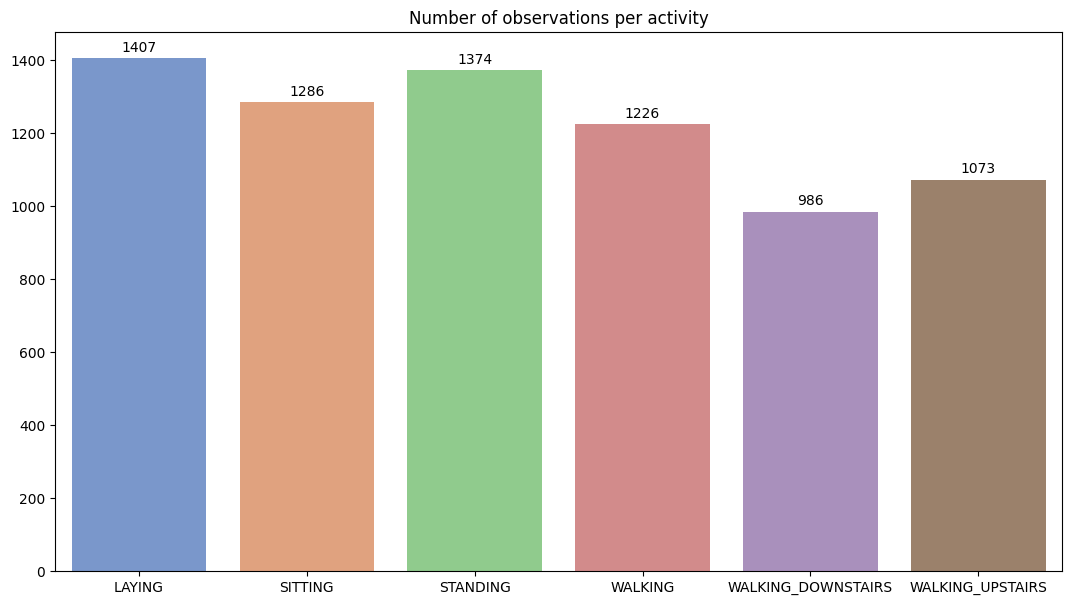

In [8]:
# Number of observations per activity
activities = train["Activity"].value_counts()
activities = activities.sort_index()
plt.figure(figsize=(13,7))
ax = sns.barplot(x = activities.index, y = activities.values, alpha=0.8, palette='muted')
ax.set(title = "Number of observations per activity")
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()+2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 7), 
                   textcoords = 'offset points')

In [9]:
# Number of windows per user (subject) and per activity
activity_df = pd.crosstab(train["subject"], train["Activity"])
activity_df

Activity,LAYING,SITTING,STANDING,WALKING,WALKING_DOWNSTAIRS,WALKING_UPSTAIRS
subject,,,,,,
1,50,47,53,95,49,53
3,62,52,61,58,49,59
5,52,44,56,56,47,47
6,57,55,57,57,48,51
7,52,48,53,57,47,51
8,54,46,54,48,38,41
11,57,53,47,59,46,54
14,51,54,60,59,45,54
15,72,59,53,54,42,48


[Text(0.5, 1.0, 'Number of activities performed by each individual')]

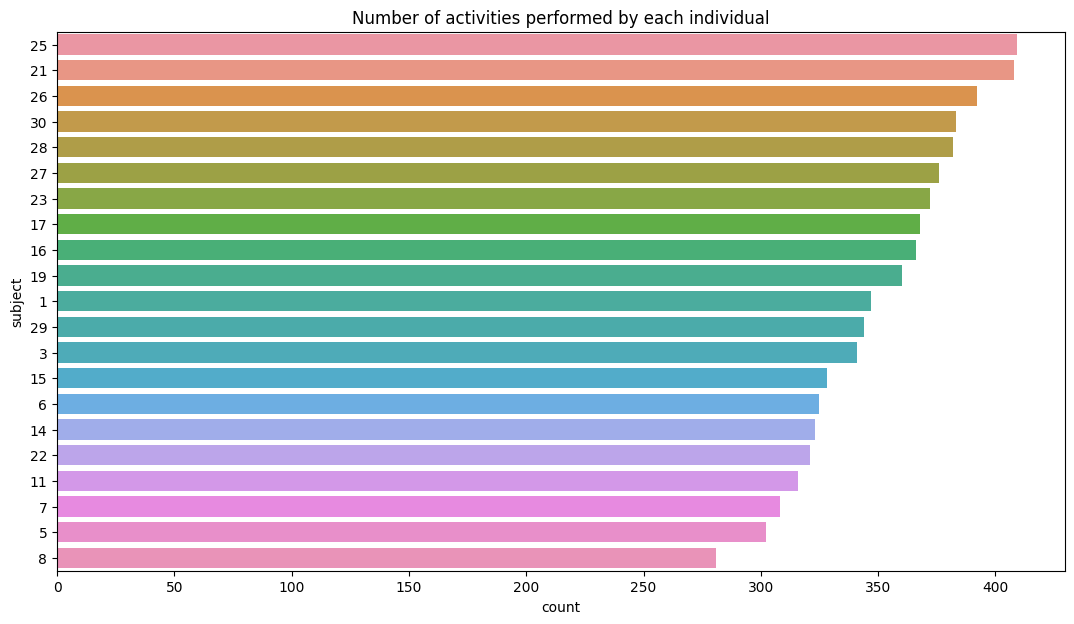

In [10]:
# Number of window activities per user
plt.figure(figsize=(13,7))
sns.countplot(y="subject", data=train, order=train["subject"].value_counts().index).set(title="Number of activities performed by each individual")

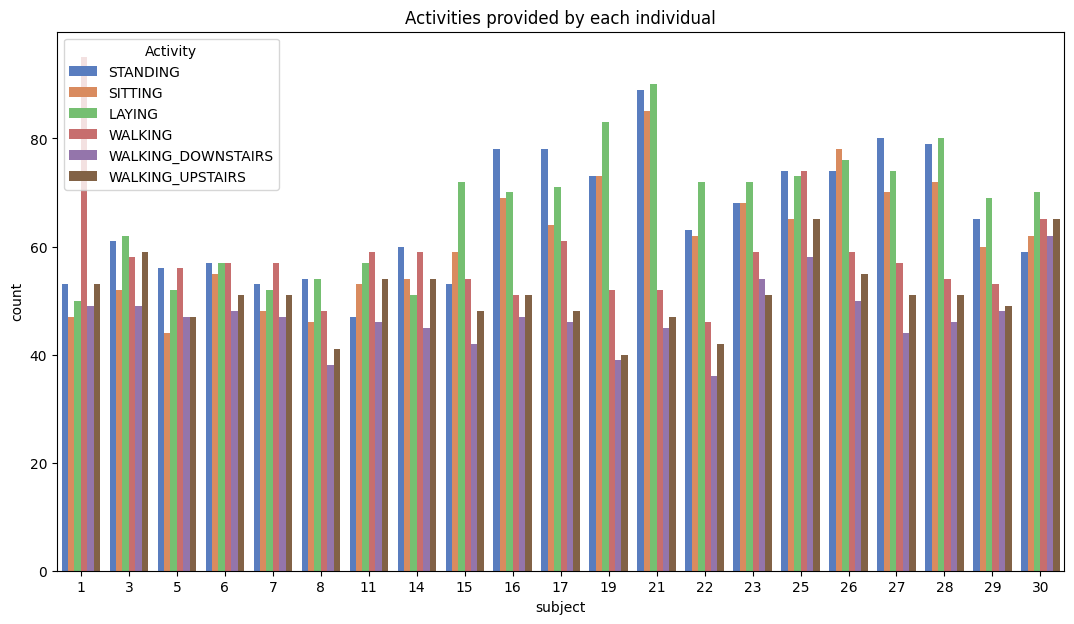

In [11]:
plt.figure(figsize=(13,7))
plt.title('Activities provided by each individual')
sns.countplot(x='subject',hue='Activity', data = train, palette='muted')
plt.show()

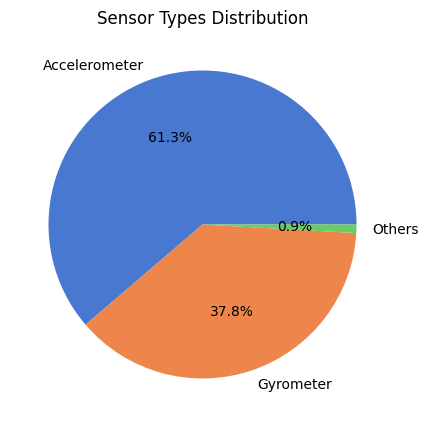

In [12]:
# Activity from Accelerometer vs Gyrometer
acc = 0
gyro = 0
others = 0

for column in train.columns:
    if "Acc" in str(column):
        acc += 1
    elif "Gyro" in str(column):
        gyro += 1
    else:
        others += 1
        
data = {
    'Sensor Type': ['Accelerometer', 'Gyrometer', 'Others'],
    'Count': [acc, gyro, others]
}

plt.figure(figsize=(8, 5))
colors = sns.color_palette('muted')
plt.pie(data['Count'], labels=data['Sensor Type'], colors=colors, autopct='%1.1f%%')
plt.title('Sensor Types Distribution')
plt.show()

#### Train - test split

In [13]:
# Train - test split
## Dependent variable: "Activity"
X_train = train.drop(["subject", "Activity"], axis=1)
y_train = train.Activity

X_test = test.drop(["subject", "Activity"], axis=1)
y_test = test.Activity

print(f"Training data size: {X_train.shape}")
print(f"Test data size: {X_test.shape}")

Training data size: (7352, 561)
Test data size: (2947, 561)


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 7352 samples in 0.067s...
[t-SNE] Computed neighbors for 7352 samples in 7.136s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7352
[t-SNE] Computed conditional probabilities for sample 2000 / 7352
[t-SNE] Computed conditional probabilities for sample 3000 / 7352
[t-SNE] Computed conditional probabilities for sample 4000 / 7352
[t-SNE] Computed conditional probabilities for sample 5000 / 7352
[t-SNE] Computed conditional probabilities for sample 6000 / 7352
[t-SNE] Computed conditional probabilities for sample 7000 / 7352
[t-SNE] Computed conditional probabilities for sample 7352 / 7352
[t-SNE] Mean sigma: 1.437672
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.090317
[t-SNE] KL divergence after 1000 iterations: 1.295007


[Text(0.5, 1.0, 'Activity Segmentation with T-SNE')]

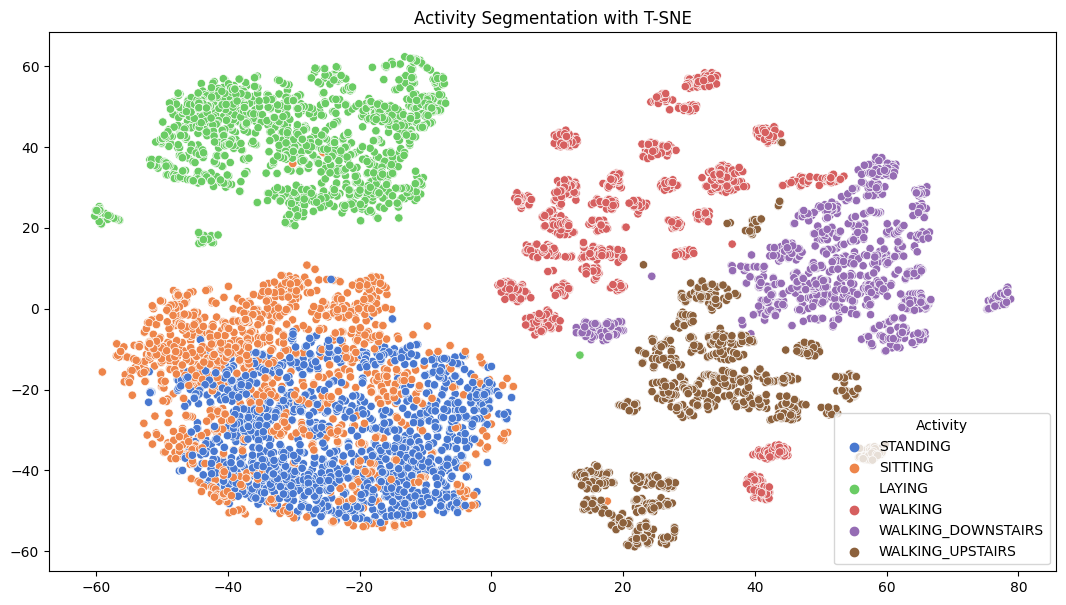

In [ ]:
# TSNE
tsne = TSNE(random_state = 42, n_components=2, verbose=1, perplexity=50, n_iter=1000).fit_transform(X_train)
plt.figure(figsize=(13,7))
sns.scatterplot(x =tsne[:, 0], y = tsne[:, 1], hue = train["Activity"],palette="muted").set(title="Activity Segmentation with T-SNE")

In [14]:
# Scaling and Encoding Data
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

scaling_data = MinMaxScaler()
X_train = scaling_data.fit_transform(X_train)
X_test = scaling_data.transform(X_test)

In [15]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((7352, 561), (7352,), (2947, 561), (2947,))

In [16]:
# Identify the original categories and their encoded values
class_codes = le.classes_
class_labels = le.transform(class_codes)

# Print the original categories and their encoded values
for code, label in zip(class_codes, class_labels):
    print(label, code)

0 LAYING
1 SITTING
2 STANDING
3 WALKING
4 WALKING_DOWNSTAIRS
5 WALKING_UPSTAIRS


### Train Model

##### Base Model - DNN (MLP)

###### DNN 1 (1 Dense + 1 Dropout only)

In [17]:
base_model = Sequential()
base_model.add(Dense(64, kernel_initializer= "normal", input_dim = X_train.shape[1], activation = "sigmoid"))
base_model.add(Dropout(0.2))
base_model.add(Dense(6, kernel_initializer = "normal",activation="softmax"))

base_model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                35968     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 6)                 390       
                                                                 
Total params: 36,358
Trainable params: 36,358
Non-trainable params: 0
_________________________________________________________________


In [18]:
earlystopping = EarlyStopping(patience=10, monitor="val_accuracy", restore_best_weights=True)
basemodel = base_model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 50, callbacks = [earlystopping])

Epoch 1/50
230/230 [==============================] - 6s 15ms/step - loss: 1.1567 - accuracy: 0.5438 - val_loss: 0.8505 - val_accuracy: 0.8039
Epoch 2/50
230/230 [==============================] - 4s 16ms/step - loss: 0.6584 - accuracy: 0.7950 - val_loss: 0.5251 - val_accuracy: 0.8127
Epoch 3/50
230/230 [==============================] - 3s 12ms/step - loss: 0.4334 - accuracy: 0.8644 - val_loss: 0.3751 - val_accuracy: 0.9006
Epoch 4/50
230/230 [==============================] - 2s 10ms/step - loss: 0.3232 - accuracy: 0.8961 - val_loss: 0.2982 - val_accuracy: 0.9043
Epoch 5/50
230/230 [==============================] - 2s 9ms/step - loss: 0.2525 - accuracy: 0.9208 - val_loss: 0.2569 - val_accuracy: 0.9104
Epoch 6/50
230/230 [==============================] - 3s 11ms/step - loss: 0.2140 - accuracy: 0.9289 - val_loss: 0.2217 - val_accuracy: 0.9175
Epoch 7/50
230/230 [==============================] - 2s 8ms/step - loss: 0.1873 - accuracy: 0.9362 - val_loss: 0.2080 - val_accuracy: 0.9138
E

In [ ]:
# loss = basemodel.history['loss']
# accuracy = basemodel.history['accuracy']
# val_loss = basemodel.history['val_loss']
# val_acc = basemodel.history['val_accuracy']

# plt.figure(figsize=(13, 7))
# plt.plot(accuracy, 'r', label='Accuracy of training data')
# plt.plot(val_acc, 'b', label='Accuracy of validation data')
# plt.plot(loss, 'r--', label='Loss of training data')
# plt.plot(val_loss, 'b--', label='Loss of validation data')

# plt.title('Base Model DNN - Accuracy and Loss')
# plt.ylabel('Accuracy and Loss')
# plt.xlabel('Training Epoch')
# plt.ylim(0)
# plt.legend()
# plt.show()

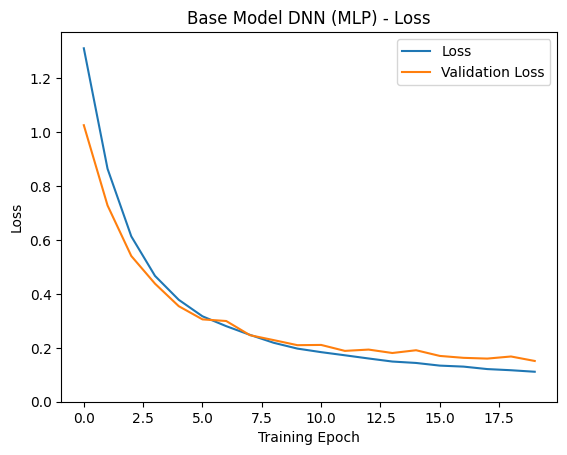

In [24]:
# Plot loss vs val loss
loss = basemodel.history['loss']
val_loss = basemodel.history['val_loss']
plt.plot(loss, label='Loss')
plt.plot(val_loss, label='Validation Loss')

plt.title('Base Model DNN (MLP) - Loss')
plt.ylabel('Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

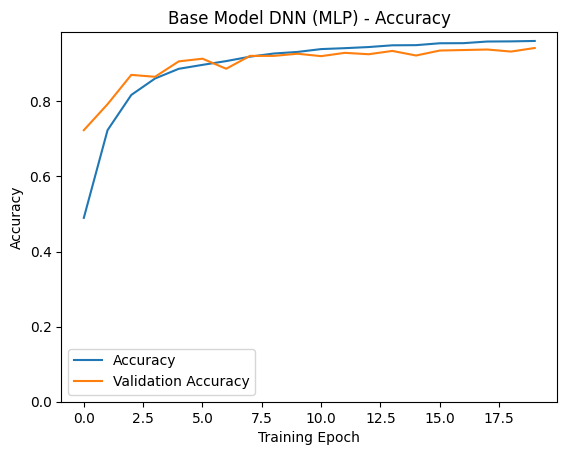

In [25]:
# Plot accuracy vs val accuracy
accuracy = basemodel.history['accuracy']
val_acc = basemodel.history['val_accuracy']
plt.plot(accuracy, label='Accuracy')
plt.plot(val_acc, label='Validation Accuracy')

plt.title('Base Model DNN (MLP) - Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

In [19]:
# Evaluate the model on the test data
loss, accuracy = base_model.evaluate(X_test, y_test)

print("Test Loss:", round(loss,4))
print("Test Accuracy:", round(accuracy,4))

93/93 [==============================] - 0s 2ms/step - loss: 0.1245 - accuracy: 0.9552
Test Loss: 0.1245
Test Accuracy: 0.9552


In [20]:
# Print classification report for test data
ypred = base_model.predict(X_test)

# Take the class with the highest probability from the test
max_ypred = np.argmax(ypred, axis=1)
print(classification_report(y_test, max_ypred))

93/93 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       537
           1       0.94      0.92      0.93       491
           2       0.92      0.95      0.93       532
           3       0.99      0.97      0.98       496
           4       0.97      0.93      0.95       420
           5       0.92      0.98      0.95       471

    accuracy                           0.96      2947
   macro avg       0.96      0.95      0.95      2947
weighted avg       0.96      0.96      0.96      2947



In [21]:
# Print classification report for training data
ypred_train = base_model.predict(X_train)

# Take the class with the highest probability from the train predictions
max_ypred_train = np.argmax(ypred_train, axis=1)
print(classification_report(y_train, max_ypred_train))

230/230 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1407
           1       0.94      0.98      0.96      1286
           2       0.98      0.94      0.96      1374
           3       1.00      1.00      1.00      1226
           4       1.00      1.00      1.00       986
           5       1.00      1.00      1.00      1073

    accuracy                           0.98      7352
   macro avg       0.98      0.99      0.98      7352
weighted avg       0.98      0.98      0.98      7352



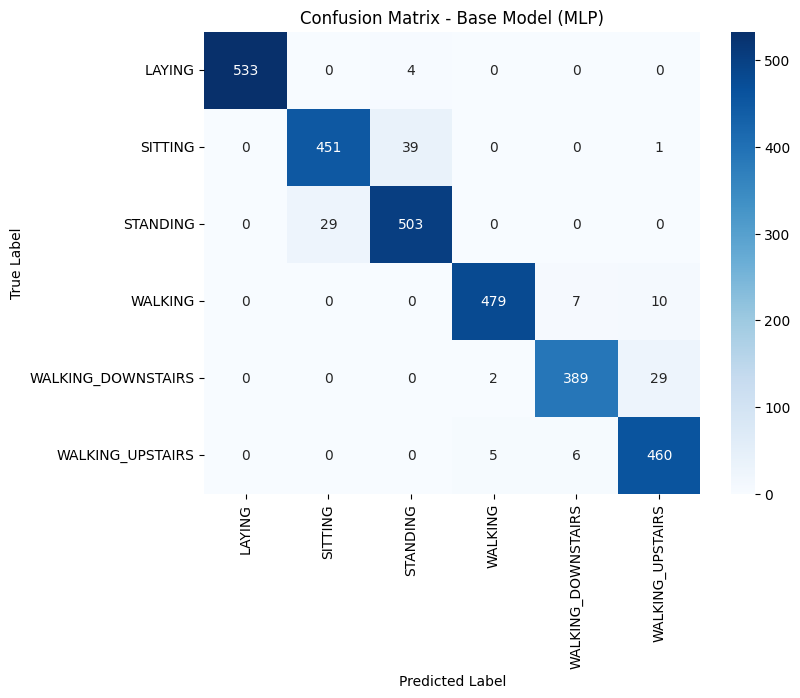

In [22]:
# Compute confusion matrix for test data
cm = confusion_matrix(y_test, max_ypred)

# Get the class labels from the LabelEncoder
class_labels = le.classes_

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix - Base Model (MLP)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

###### DNN 2 (3 Dense Layers + 1 Dropout)

In [55]:
base_model2 = Sequential()
base_model2.add(Dense(64, kernel_initializer = "uniform", input_dim = X_train.shape[1]))
base_model.add(Dropout(0.5))
base_model2.add(Dense(64, kernel_initializer = "uniform", activation = "relu"))
base_model2.add(Dense(64, kernel_initializer = "uniform", activation = "relu"))
base_model2.add(Dense(6, kernel_initializer = "uniform", activation="softmax"))

base_model2.compile(optimizer = "adam",loss = "sparse_categorical_crossentropy", metrics=['accuracy'])
base_model2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 64)                35968     
                                                                 
 dense_13 (Dense)            (None, 64)                4160      
                                                                 
 dense_14 (Dense)            (None, 64)                4160      
                                                                 
 dense_15 (Dense)            (None, 6)                 390       
                                                                 
Total params: 44,678
Trainable params: 44,678
Non-trainable params: 0
_________________________________________________________________


In [56]:
earlystopping = EarlyStopping(patience=10, monitor="val_accuracy", restore_best_weights=True)
bmodel = base_model2.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=50, batch_size=64, callbacks = [earlystopping])

Epoch 1/50
115/115 [==============================] - 2s 6ms/step - loss: 1.1755 - accuracy: 0.4034 - val_loss: 1.0040 - val_accuracy: 0.4150
Epoch 2/50
115/115 [==============================] - 0s 4ms/step - loss: 0.7305 - accuracy: 0.6704 - val_loss: 0.5793 - val_accuracy: 0.7078
Epoch 3/50
115/115 [==============================] - 1s 5ms/step - loss: 0.4485 - accuracy: 0.8022 - val_loss: 0.4475 - val_accuracy: 0.7988
Epoch 4/50
115/115 [==============================] - 0s 4ms/step - loss: 0.3084 - accuracy: 0.8795 - val_loss: 0.2769 - val_accuracy: 0.8958
Epoch 5/50
115/115 [==============================] - 1s 5ms/step - loss: 0.2032 - accuracy: 0.9159 - val_loss: 0.2640 - val_accuracy: 0.9084
Epoch 6/50
115/115 [==============================] - 1s 4ms/step - loss: 0.1615 - accuracy: 0.9343 - val_loss: 0.2288 - val_accuracy: 0.9253
Epoch 7/50
115/115 [==============================] - 1s 5ms/step - loss: 0.1389 - accuracy: 0.9437 - val_loss: 0.2042 - val_accuracy: 0.9169
Epoch 

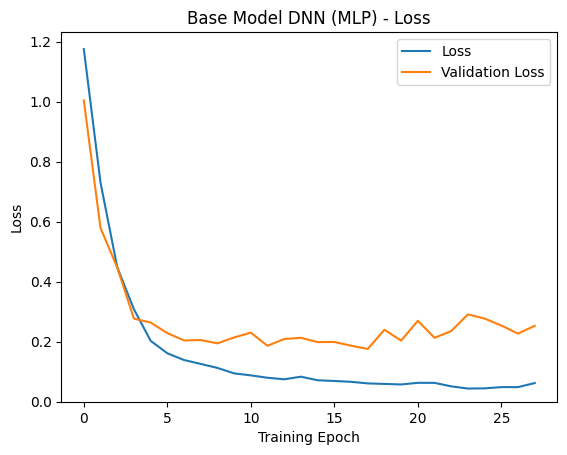

In [57]:
# Plot loss vs val loss
loss = bmodel.history['loss']
val_loss = bmodel.history['val_loss']
plt.plot(loss, label='Loss')
plt.plot(val_loss, label='Validation Loss')

plt.title('Base Model DNN (MLP) - Loss')
plt.ylabel('Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

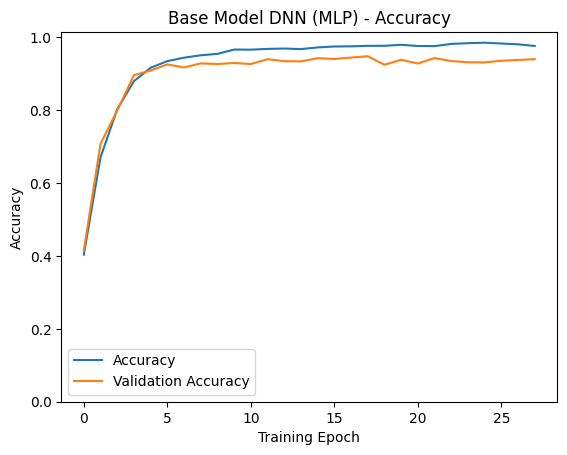

In [58]:
# Plot accuracy vs val accuracy
accuracy = bmodel.history['accuracy']
val_acc = bmodel.history['val_accuracy']
plt.plot(accuracy, label='Accuracy')
plt.plot(val_acc, label='Validation Accuracy')

plt.title('Base Model DNN (MLP) - Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

In [59]:
# Evaluate the model on the test data
loss, accuracy = base_model2.evaluate(X_test, y_test)

print("Test Loss:", round(loss,4))
print("Test Accuracy:", round(accuracy,4))

93/93 [==============================] - 0s 2ms/step - loss: 0.1760 - accuracy: 0.9477
Test Loss: 0.176
Test Accuracy: 0.9477


In [60]:
# Print classification report for test data
ypred = base_model2.predict(X_test)

# Take the class with the highest probability from the test
max_ypred = np.argmax(ypred, axis=1)
print(classification_report(y_test, max_ypred))

93/93 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       1.00      0.95      0.97       537
           1       0.90      0.91      0.91       491
           2       0.92      0.96      0.94       532
           3       0.98      0.97      0.97       496
           4       0.97      0.93      0.95       420
           5       0.92      0.97      0.95       471

    accuracy                           0.95      2947
   macro avg       0.95      0.95      0.95      2947
weighted avg       0.95      0.95      0.95      2947



In [61]:
# Print classification report for training data
ypred_train = base_model2.predict(X_train)

# Take the class with the highest probability from the train predictions
max_ypred_train = np.argmax(ypred_train, axis=1)
print(classification_report(y_train, max_ypred_train))

230/230 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1407
           1       0.95      0.96      0.96      1286
           2       0.97      0.96      0.96      1374
           3       1.00      0.99      1.00      1226
           4       0.98      1.00      0.99       986
           5       0.99      0.99      0.99      1073

    accuracy                           0.98      7352
   macro avg       0.98      0.98      0.98      7352
weighted avg       0.98      0.98      0.98      7352



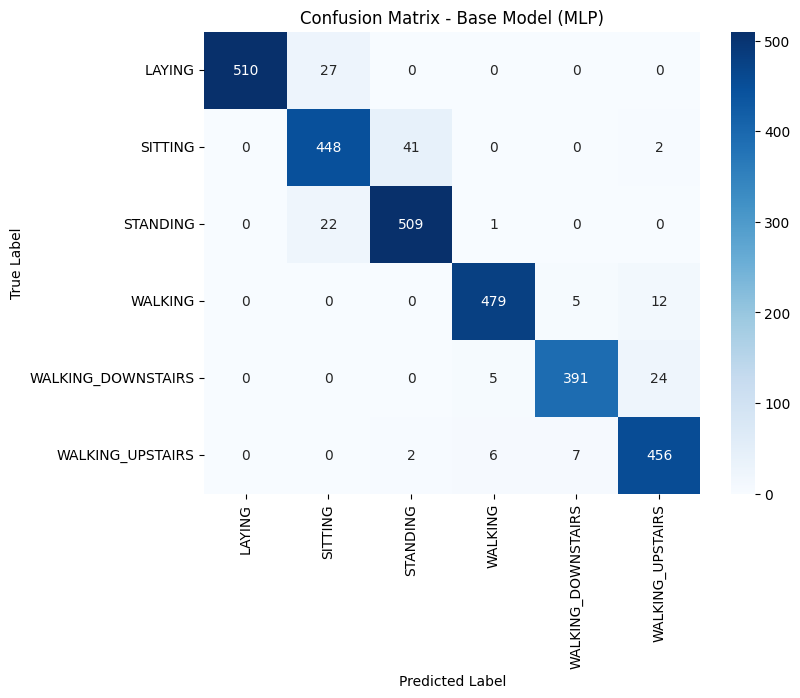

In [62]:
# Compute confusion matrix for test data
cm = confusion_matrix(y_test, max_ypred)

# Get the class labels from the LabelEncoder
class_labels = le.inverse_transform(np.unique(y_test))

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix - Base Model (MLP)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

##### CNN Model

In [32]:
# Reshape training data
X_train = np.array(X_train)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

# Reshape test data
X_test = np.array(X_test)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [42]:
model_cnn = Sequential()
model_cnn.add(Input(shape = X_train.shape[1:]))
model_cnn.add(Conv1D(64, 3, activation = "relu"))
model_cnn.add(Conv1D(32, 3, activation = "relu"))
model_cnn.add(Dropout(0.2))
model_cnn.add(Flatten())
model_cnn.add(Dense(64, activation = "relu"))
model_cnn.add(Dense(128, activation = "relu"))
model_cnn.add(Dense(6, activation="softmax"))

model_cnn.compile(optimizer="SGD", loss="sparse_categorical_crossentropy", metrics=['accuracy'])
model_cnn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 559, 64)           256       
                                                                 
 conv1d_1 (Conv1D)           (None, 557, 32)           6176      
                                                                 
 dropout_4 (Dropout)         (None, 557, 32)           0         
                                                                 
 flatten (Flatten)           (None, 17824)             0         
                                                                 
 dense_7 (Dense)             (None, 64)                1140800   
                                                                 
 dense_8 (Dense)             (None, 128)               8320      
                                                                 
 dense_9 (Dense)             (None, 6)                

In [43]:
earlystopping = EarlyStopping(patience=10, monitor="val_accuracy", restore_best_weights=True)
cnn_history = model_cnn.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), callbacks = [earlystopping])

Epoch 1/50
115/115 [==============================] - 16s 129ms/step - loss: 1.6225 - accuracy: 0.3742 - val_loss: 1.2886 - val_accuracy: 0.4557
Epoch 2/50
115/115 [==============================] - 21s 187ms/step - loss: 1.0623 - accuracy: 0.5741 - val_loss: 0.9358 - val_accuracy: 0.6227
Epoch 3/50
115/115 [==============================] - 23s 201ms/step - loss: 0.8007 - accuracy: 0.7137 - val_loss: 0.6595 - val_accuracy: 0.8361
Epoch 4/50
115/115 [==============================] - 18s 156ms/step - loss: 0.5739 - accuracy: 0.7865 - val_loss: 0.4737 - val_accuracy: 0.8378
Epoch 5/50
115/115 [==============================] - 16s 136ms/step - loss: 0.4177 - accuracy: 0.8377 - val_loss: 0.4019 - val_accuracy: 0.8453
Epoch 6/50
115/115 [==============================] - 14s 125ms/step - loss: 0.3406 - accuracy: 0.8621 - val_loss: 0.3133 - val_accuracy: 0.8816
Epoch 7/50
115/115 [==============================] - 14s 124ms/step - loss: 0.2914 - accuracy: 0.8822 - val_loss: 0.3063 - val_ac

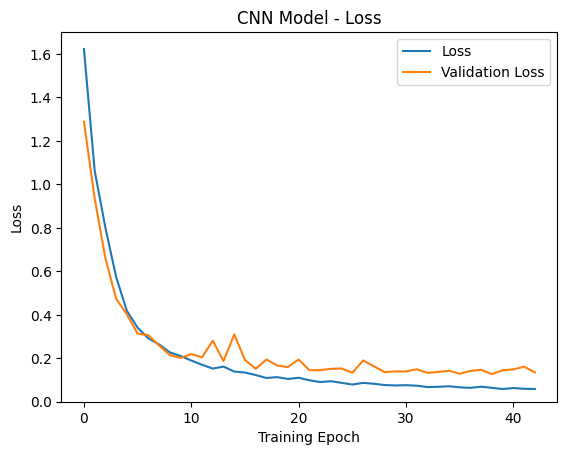

In [44]:
# Plot loss vs val loss
loss = cnn_history.history['loss']
val_loss = cnn_history.history['val_loss']
plt.plot(loss, label='Loss')
plt.plot(val_loss, label='Validation Loss')

plt.title('CNN Model - Loss')
plt.ylabel('Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

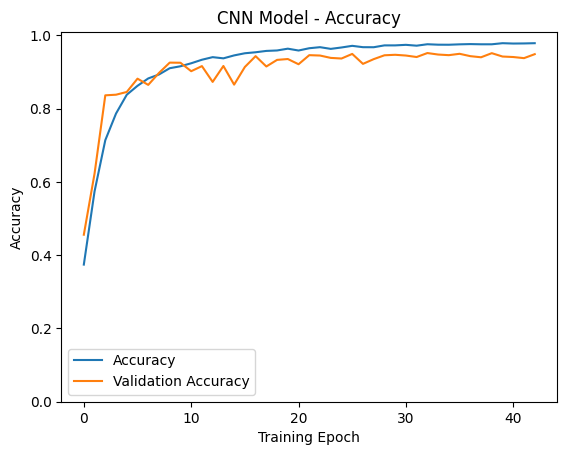

In [45]:
# Plot accuracy vs val accuracy
accuracy = cnn_history.history['accuracy']
val_acc = cnn_history.history['val_accuracy']
plt.plot(accuracy, label='Accuracy')
plt.plot(val_acc, label='Validation Accuracy')

plt.title('CNN Model - Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

In [46]:
# Evaluate the model on the test data
loss, accuracy = model_cnn.evaluate(X_test, y_test)

print("Test Loss:", round(loss,4))
print("Test Accuracy:", round(accuracy,4))

93/93 [==============================] - 1s 14ms/step - loss: 0.1328 - accuracy: 0.9515
Test Loss: 0.1328
Test Accuracy: 0.9515


In [53]:
# Print classification report for test data
cnn_ypred = model_cnn.predict(X_test)

# Take the class with the highest probability from the test
max_cnn_ypred = np.argmax(cnn_ypred, axis=1)
print(classification_report(y_test, max_cnn_ypred))

93/93 [==============================] - 1s 12ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       537
           1       0.94      0.91      0.92       491
           2       0.93      0.94      0.93       532
           3       0.92      0.98      0.95       496
           4       0.97      0.95      0.96       420
           5       0.96      0.92      0.94       471

    accuracy                           0.95      2947
   macro avg       0.95      0.95      0.95      2947
weighted avg       0.95      0.95      0.95      2947



In [54]:
# Print classification report for training data
ypred_train = model_cnn.predict(X_train)

# Take the class with the highest probability from the train predictions
max_ypred_train = np.argmax(ypred_train, axis=1)
print(classification_report(y_train, max_ypred_train))

230/230 [==============================] - 4s 18ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1407
           1       0.95      0.96      0.95      1286
           2       0.96      0.95      0.96      1374
           3       0.99      1.00      1.00      1226
           4       1.00      1.00      1.00       986
           5       1.00      0.99      1.00      1073

    accuracy                           0.98      7352
   macro avg       0.98      0.98      0.98      7352
weighted avg       0.98      0.98      0.98      7352



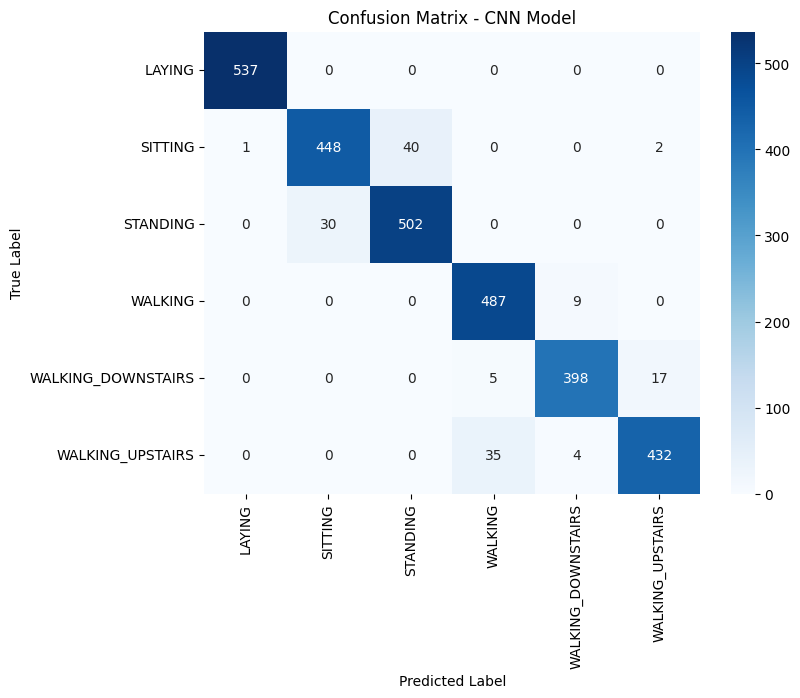

In [52]:
# Compute confusion matrix for test data
cm = confusion_matrix(y_test, max_cnn_ypred)

# Get the class labels from the LabelEncoder
class_labels = le.classes_

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix - CNN Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

##### LSTM Model

In [33]:
model_LSTM = Sequential()
model_LSTM.add(Input(shape=X_train.shape[1:]))
model_LSTM.add(LSTM(48, return_sequences=True))
model_LSTM.add(BatchNormalization())
model_LSTM.add(Dropout(0.5))
model_LSTM.add(LSTM(32, kernel_regularizer=regularizers.l2(0.001)))
model_LSTM.add(Dropout(0.5))
model_LSTM.add(Dense(6, activation="softmax"))

model_LSTM.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=['accuracy'])
model_LSTM.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 561, 48)           9600      
                                                                 
 batch_normalization (BatchN  (None, 561, 48)          192       
 ormalization)                                                   
                                                                 
 dropout_2 (Dropout)         (None, 561, 48)           0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                10368     
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_6 (Dense)             (None, 6)                 198       
                                                      

In [34]:
earlystopping = EarlyStopping(patience=10, monitor="val_accuracy", restore_best_weights=True)
LSTM_history = model_LSTM.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 50, batch_size = 64, callbacks = [earlystopping])

Epoch 1/50
154/154 [==============================] - 120s 751ms/step - loss: 1.3640 - accuracy: 0.3663 - val_loss: 1.6617 - val_accuracy: 0.2480
Epoch 2/50
154/154 [==============================] - 106s 688ms/step - loss: 1.0983 - accuracy: 0.5094 - val_loss: 1.2882 - val_accuracy: 0.4096
Epoch 3/50
154/154 [==============================] - 106s 689ms/step - loss: 0.9038 - accuracy: 0.6269 - val_loss: 1.0746 - val_accuracy: 0.5860
Epoch 4/50
154/154 [==============================] - 105s 680ms/step - loss: 0.8115 - accuracy: 0.6702 - val_loss: 2.4288 - val_accuracy: 0.4371
Epoch 5/50
154/154 [==============================] - 103s 667ms/step - loss: 0.7604 - accuracy: 0.6908 - val_loss: 0.7904 - val_accuracy: 0.6474
Epoch 6/50
154/154 [==============================] - 99s 642ms/step - loss: 0.7166 - accuracy: 0.7119 - val_loss: 1.4874 - val_accuracy: 0.5144
Epoch 7/50
154/154 [==============================] - 96s 625ms/step - loss: 0.6890 - accuracy: 0.7239 - val_loss: 3.9614 - v

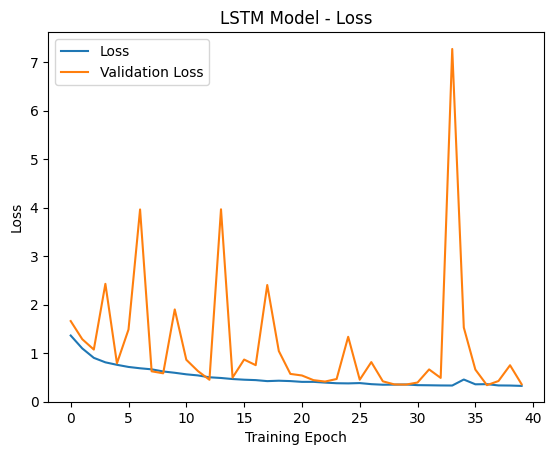

In [40]:
# Plot loss vs val loss
loss = LSTM_history.history['loss']
val_loss = LSTM_history.history['val_loss']
plt.plot(loss, label='Loss')
plt.plot(val_loss, label='Validation Loss')

plt.title('LSTM Model - Loss')
plt.ylabel('Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

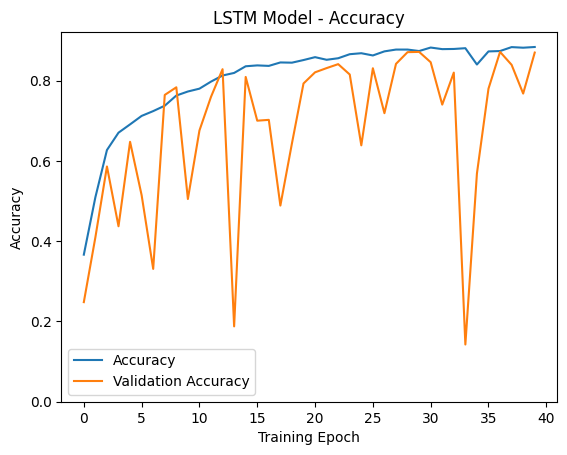

In [41]:
# Plot accuracy vs val accuracy
accuracy = LSTM_history.history['accuracy']
val_acc = LSTM_history.history['val_accuracy']
plt.plot(accuracy, label='Accuracy')
plt.plot(val_acc, label='Validation Accuracy')

plt.title('LSTM Model - Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

In [37]:
# Evaluate the model on the test data
loss, accuracy = model_LSTM.evaluate(X_test, y_test)

print("Test Loss:", round(loss,4))
print("Test Accuracy:", round(accuracy,4))

93/93 [==============================] - 12s 132ms/step - loss: 0.3530 - accuracy: 0.8714
Test Loss: 0.353
Test Accuracy: 0.8714


In [39]:
# Print classification report for test data
lstm_ypred = model_LSTM.predict(X_test)

# Take the class with the highest probability from the test
max_lstm_ypred = np.argmax(lstm_ypred, axis=1)
print(classification_report(y_test, max_lstm_ypred))

93/93 [==============================] - 16s 173ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       537
           1       0.90      0.69      0.78       491
           2       0.77      0.92      0.84       532
           3       0.91      0.88      0.90       496
           4       0.82      0.86      0.84       420
           5       0.85      0.86      0.86       471

    accuracy                           0.87      2947
   macro avg       0.87      0.87      0.87      2947
weighted avg       0.88      0.87      0.87      2947



In [38]:
# Print classification report for training data
lstm_ypred_train = model_LSTM.predict(X_train)

# Take the class with the highest probability from the train predictions
max_lstm_ypred_train = np.argmax(lstm_ypred_train, axis=1)
print(classification_report(y_train, max_lstm_ypred_train))

230/230 [==============================] - 49s 209ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1407
           1       0.91      0.77      0.83      1286
           2       0.82      0.93      0.87      1374
           3       0.96      0.89      0.93      1226
           4       0.84      0.95      0.89       986
           5       0.88      0.87      0.88      1073

    accuracy                           0.90      7352
   macro avg       0.90      0.90      0.90      7352
weighted avg       0.90      0.90      0.90      7352



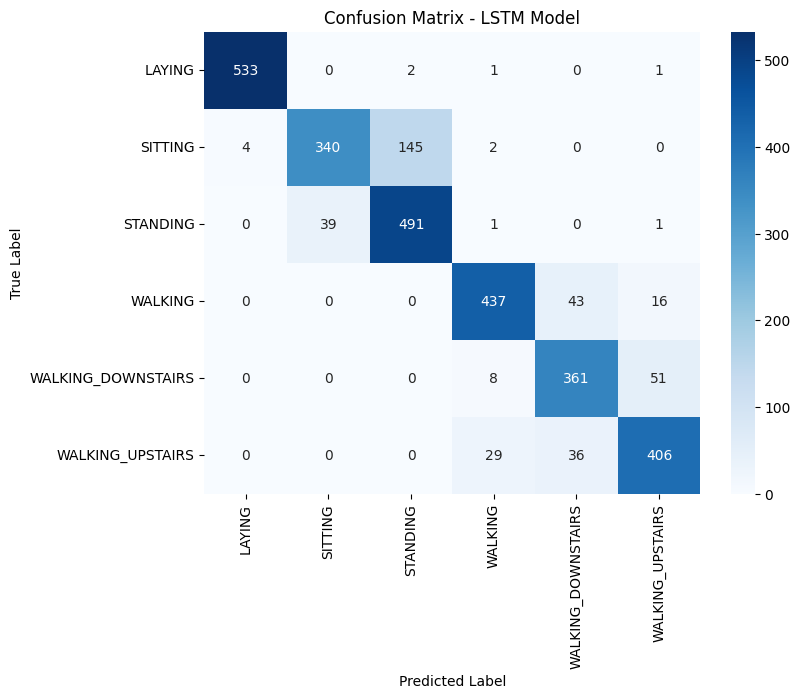

In [75]:
# Compute confusion matrix for test data
cm = confusion_matrix(y_test, max_lstm_ypred)

# Get the class labels from the LabelEncoder
class_labels = le.classes_

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix - LSTM Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

##### CNN + LSTM model

In [66]:
CNN_LSTM_model = Sequential()
CNN_LSTM_model.add(Input(shape=X_train.shape[1:]))
CNN_LSTM_model.add(Conv1D(64, 3, activation="relu"))
CNN_LSTM_model.add(Conv1D(128, 3, activation="relu"))
CNN_LSTM_model.add(Dropout(0.5))
CNN_LSTM_model.add(MaxPooling1D(pool_size=2))
CNN_LSTM_model.add(LSTM(64, activation="tanh", kernel_regularizer=l2(0.01)))
CNN_LSTM_model.add(Dropout(0.5))
CNN_LSTM_model.add(Dense(128, activation="relu"))
CNN_LSTM_model.add(Dense(6, activation="softmax"))

# Compile the model
CNN_LSTM_model.compile(optimizer=Adam(learning_rate=0.001),
                       loss="sparse_categorical_crossentropy",
                       metrics=['accuracy'])
CNN_LSTM_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 559, 64)           256       
                                                                 
 conv1d_9 (Conv1D)           (None, 557, 128)          24704     
                                                                 
 dropout_12 (Dropout)        (None, 557, 128)          0         
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 278, 128)         0         
 1D)                                                             
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_13 (Dropout)        (None, 64)                0         
                                                      

In [ ]:
earlystopping = EarlyStopping(patience=10, monitor="val_accuracy", restore_best_weights=True)
cnn_lstm_history = CNN_LSTM_model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), callbacks = [earlystopping])

Epoch 1/50
115/115 [==============================] - 100s 788ms/step - loss: 1.9961 - accuracy: 0.3180 - val_loss: 1.3729 - val_accuracy: 0.3424
Epoch 2/50
115/115 [==============================] - 88s 766ms/step - loss: 1.1675 - accuracy: 0.4431 - val_loss: 1.1300 - val_accuracy: 0.4540
Epoch 3/50
115/115 [==============================] - 85s 738ms/step - loss: 1.0468 - accuracy: 0.5048 - val_loss: 1.0513 - val_accuracy: 0.5558
Epoch 4/50
115/115 [==============================] - 87s 760ms/step - loss: 0.9743 - accuracy: 0.5510 - val_loss: 1.0889 - val_accuracy: 0.4306
Epoch 5/50
115/115 [==============================] - 89s 773ms/step - loss: 0.9344 - accuracy: 0.5687 - val_loss: 1.0031 - val_accuracy: 0.5395
Epoch 6/50
115/115 [==============================] - 85s 744ms/step - loss: 0.8826 - accuracy: 0.6113 - val_loss: 0.7815 - val_accuracy: 0.6807
Epoch 7/50
115/115 [==============================] - 88s 764ms/step - loss: 0.7448 - accuracy: 0.6839 - val_loss: 0.6609 - val_a

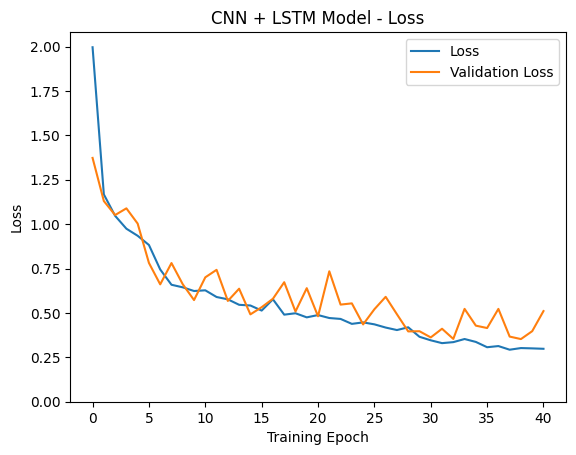

In [ ]:
# Plot loss vs val loss
loss = cnn_lstm_history.history['loss']
val_loss = cnn_lstm_history.history['val_loss']
plt.plot(loss, label='Loss')
plt.plot(val_loss, label='Validation Loss')

plt.title('CNN + LSTM Model - Loss')
plt.ylabel('Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

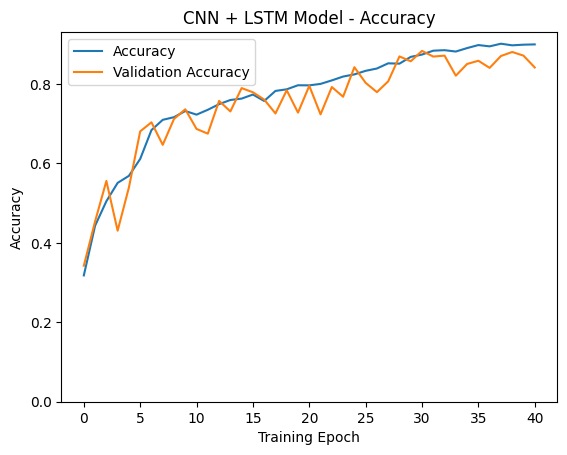

In [ ]:
# Plot accuracy vs val accuracy
accuracy = cnn_lstm_history.history['accuracy']
val_acc = cnn_lstm_history.history['val_accuracy']
plt.plot(accuracy, label='Accuracy')
plt.plot(val_acc, label='Validation Accuracy')

plt.title('CNN + LSTM Model - Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

In [ ]:
# Evaluate the model on the test data
loss, accuracy = CNN_LSTM_model.evaluate(X_test, y_test)

print("Test Loss:", round(loss,4))
print("Test Accuracy:", round(accuracy,4))

93/93 [==============================] - 7s 70ms/step - loss: 0.3622 - accuracy: 0.8833
Test Loss: 0.3622
Test Accuracy: 0.8833


In [ ]:
# Print classification report for test data
cnn_lstm_ypred = CNN_LSTM_model.predict(X_test)

# Take the class with the highest probability from the test
max_cnn_lstm_ypred = np.argmax(cnn_lstm_ypred, axis=1)
print('CNN + LSTM Model - Classification Report:')
print(classification_report(y_test, max_cnn_lstm_ypred))

93/93 [==============================] - 8s 75ms/step
CNN + LSTM Model - Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       537
           1       0.90      0.63      0.74       491
           2       0.76      0.93      0.84       532
           3       0.88      0.97      0.93       496
           4       0.93      0.85      0.88       420
           5       0.91      0.91      0.91       471

    accuracy                           0.88      2947
   macro avg       0.89      0.88      0.88      2947
weighted avg       0.89      0.88      0.88      2947



In [ ]:
# Print confusion matrix for training data
ypred_train = CNN_LSTM_model.predict(X_train)

# Take the class with the highest probability from the train predictions
max_ypred_train = np.argmax(ypred_train, axis=1)
print(classification_report(y_train, max_ypred_train))

230/230 [==============================] - 18s 77ms/step
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1407
           1       0.92      0.75      0.83      1286
           2       0.83      0.94      0.88      1374
           3       0.96      0.98      0.97      1226
           4       0.97      0.91      0.94       986
           5       0.92      0.96      0.94      1073

    accuracy                           0.92      7352
   macro avg       0.93      0.92      0.92      7352
weighted avg       0.93      0.92      0.92      7352



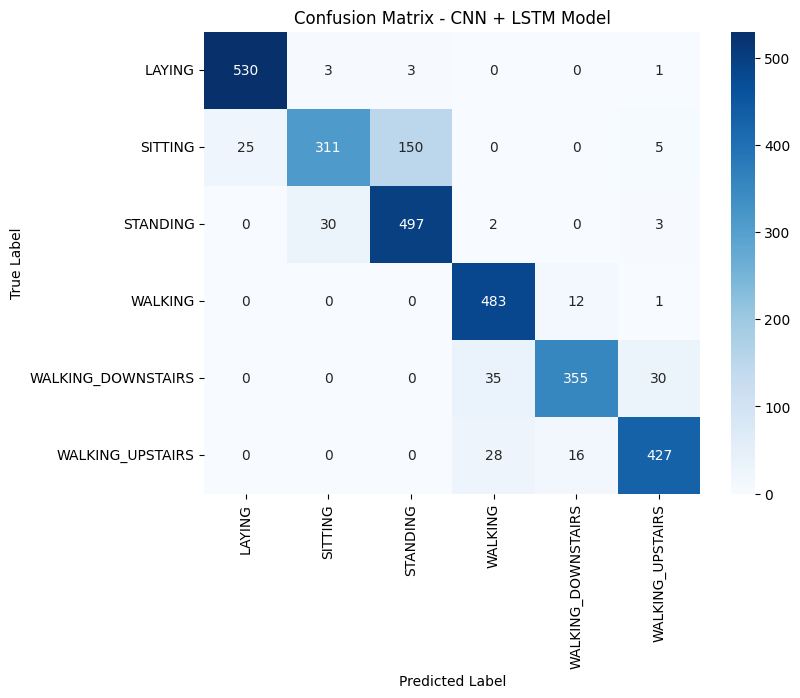

In [ ]:
# Compute confusion matrix for test data
cm = confusion_matrix(y_test, max_cnn_lstm_ypred)

# Get the class labels from the LabelEncoder
class_labels = le.classes_

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix - CNN + LSTM Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()